# 0.0 Introduction
This notebook will describe an algorithm which will take in reduced spectra and perform PCA

# 0.1 First pass

The first pass will have no care for error. The formatting of the data is faily poor this is just to get something acceptable working. There is also no science behind the sample selection. What type of stars do we wish to look at, what brightness, intersetllar dust extinction. This is just taking a certain random sample of HR10 and seeing what we can learn. Consider
https://arxiv.org/pdf/1001.4340.pdf

# 0.2 Imports

In [1]:
from astropy.io import fits
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn

if("Analysis" in os.getcwd()):
    os.chdir("../")
from Data_handling.spectra_object import Spectrum, learning_data
from Data_handling.pca_functions import Pca_Fitting

os.chdir("Analysis")
os.getcwd()

'/Users/mattocallaghan/Documents/GES/Analysis'

# 1.0 Data input for HR10 Sample

A sample of HR10 Giraffe spectra have been selected. We will use the data handling function to create a list of these
spectra with their object names. We will get a list of spectrum classes.

We will save the sample but this code will need to be run again if done with different sample.

In [2]:
'''
os.chdir("../Data")  #change to data set folder and get the file names
mypath=os.getcwd()
spectra = [f for f in listdir(mypath) if (isfile(join(mypath, f))and('.fits'in f))]

spectrum_list=[]
for i in range(0,1090):#len(spectra)):
    print(str(i) + ' out of ' + str(len(spectra)))
    spectrum_list.append(Spectrum(spectra[i],parameters=True)) #at the moment there are all hr10
'''

'\nos.chdir("../Data")  #change to data set folder and get the file names\nmypath=os.getcwd()\nspectra = [f for f in listdir(mypath) if (isfile(join(mypath, f))and(\'.fits\'in f))]\n\nspectrum_list=[]\nfor i in range(0,1090):#len(spectra)):\n    print(str(i) + \' out of \' + str(len(spectra)))\n    spectrum_list.append(Spectrum(spectra[i],parameters=True)) #at the moment there are all hr10\n'

In [3]:
# We now save these to a file

import pickle
os.chdir('../Data')
#with open('class','wb') as f:
#    pickle.dump(spectrum_list,f)


In [4]:
with open('class', 'rb') as f:
    spectrum_list = pickle.load(f)
os.chdir('../Analysis')
spectrum_list


 ...]

# 1.1 Parameters for these samples

Some of the parameters have been included in the above

# 1.2 Example of a spectra

Spectrum name and column names

In [5]:
spectrum=spectrum_list[0]
print(spectrum.get_object)
spectrum.get_columns()

<bound method Spectrum.get_object of <Data_handling.spectra_object.Spectrum object at 0x105eeeaf0>>


Index(['wavelength', 'flux', 'flux_err'], dtype='object')

Example of a spectrum

Plot of spectrum flux vs wavelength  
Units of wavelength are nm  
Units of flux are adu

This hasn't been included in class yet but will be.

<AxesSubplot:title={'center':'Plot of spectrum'}, xlabel='nm', ylabel='adu'>

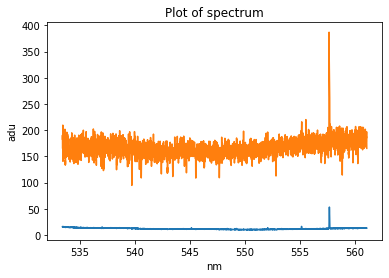

In [6]:


plt.title("Plot of spectrum")
plt.xlabel('nm')
plt.ylabel('adu')
#sn.lineplot(x=spectrum.data['wavelength'],y=spectrum.data['flux'])
sn.lineplot(x=spectrum.data['wavelength'],y=spectrum.data['flux_err'])
sn.lineplot(x=spectrum.data['wavelength'],y=spectrum.data[spectrum.data['flux_err']<=30]['flux'])


# 2.0 Principal C A

No data cleaning has been done so far.

Take the same example of a spectrum and perform PCA on it.

In [7]:
learning_spectra=[]
for i in range(0,len(spectrum_list)):
    learning_spectra.append(spectrum_list[i].data['flux'])

In [8]:
learning_spectra=np.array(learning_spectra)
np.shape(learning_spectra)

(1090, 5541)

The rows are the different spectra. Columns describe the wavelength observations

# 2.1 Algorithm setup

Define the PCA

In [9]:
pca=Pca_Fitting(learning_spectra,n_components=100)

Fit to our data

Spec fitted is the coefficients of the eigenvalues for each of the spectra.

In [10]:
np.shape(pca.spec_fitted)

#Why are there only 5207?

(1090, 100)

We should have low variance

In [11]:
pca.pca.explained_variance_ratio_

array([9.96041954e-01, 3.70940426e-03, 1.95274304e-04, 2.27512010e-05,
       8.05964282e-06, 4.61932268e-06, 3.96436644e-06, 2.24048449e-06,
       1.63905486e-06, 1.30380135e-06, 8.39781023e-07, 6.76438503e-07,
       6.40678479e-07, 5.08815901e-07, 3.97503072e-07, 3.79297944e-07,
       3.71643637e-07, 2.92440404e-07, 2.13096172e-07, 1.89858696e-07,
       1.44368244e-07, 1.23853411e-07, 1.19629874e-07, 1.04560591e-07,
       9.39947995e-08, 7.77720501e-08, 7.36119290e-08, 6.78243381e-08,
       6.11012609e-08, 5.58701174e-08, 5.17852037e-08, 4.92946235e-08,
       4.76857203e-08, 4.45444392e-08, 4.25465458e-08, 3.75112066e-08,
       3.67401256e-08, 3.36251489e-08, 3.27003029e-08, 3.07286605e-08,
       2.80515966e-08, 2.62866138e-08, 2.54710706e-08, 2.31877060e-08,
       2.17454659e-08, 2.12043982e-08, 2.06540864e-08, 1.95253449e-08,
       1.87283238e-08, 1.73629164e-08, 1.72034262e-08, 1.58837015e-08,
       1.57151376e-08, 1.52820334e-08, 1.45357948e-08, 1.39112419e-08,
      

So the spectrum should look like

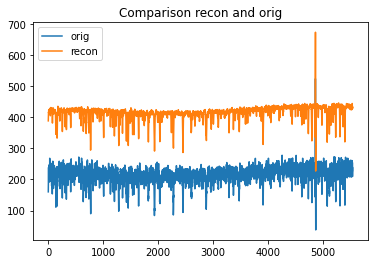

In [12]:
#example for first spectrum
pca.plot_orig_and_recon_w_offset(1)

# 2.2 Fit of PCA

Start with plotting MSE per components and looking at reconstruction for different fits.

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


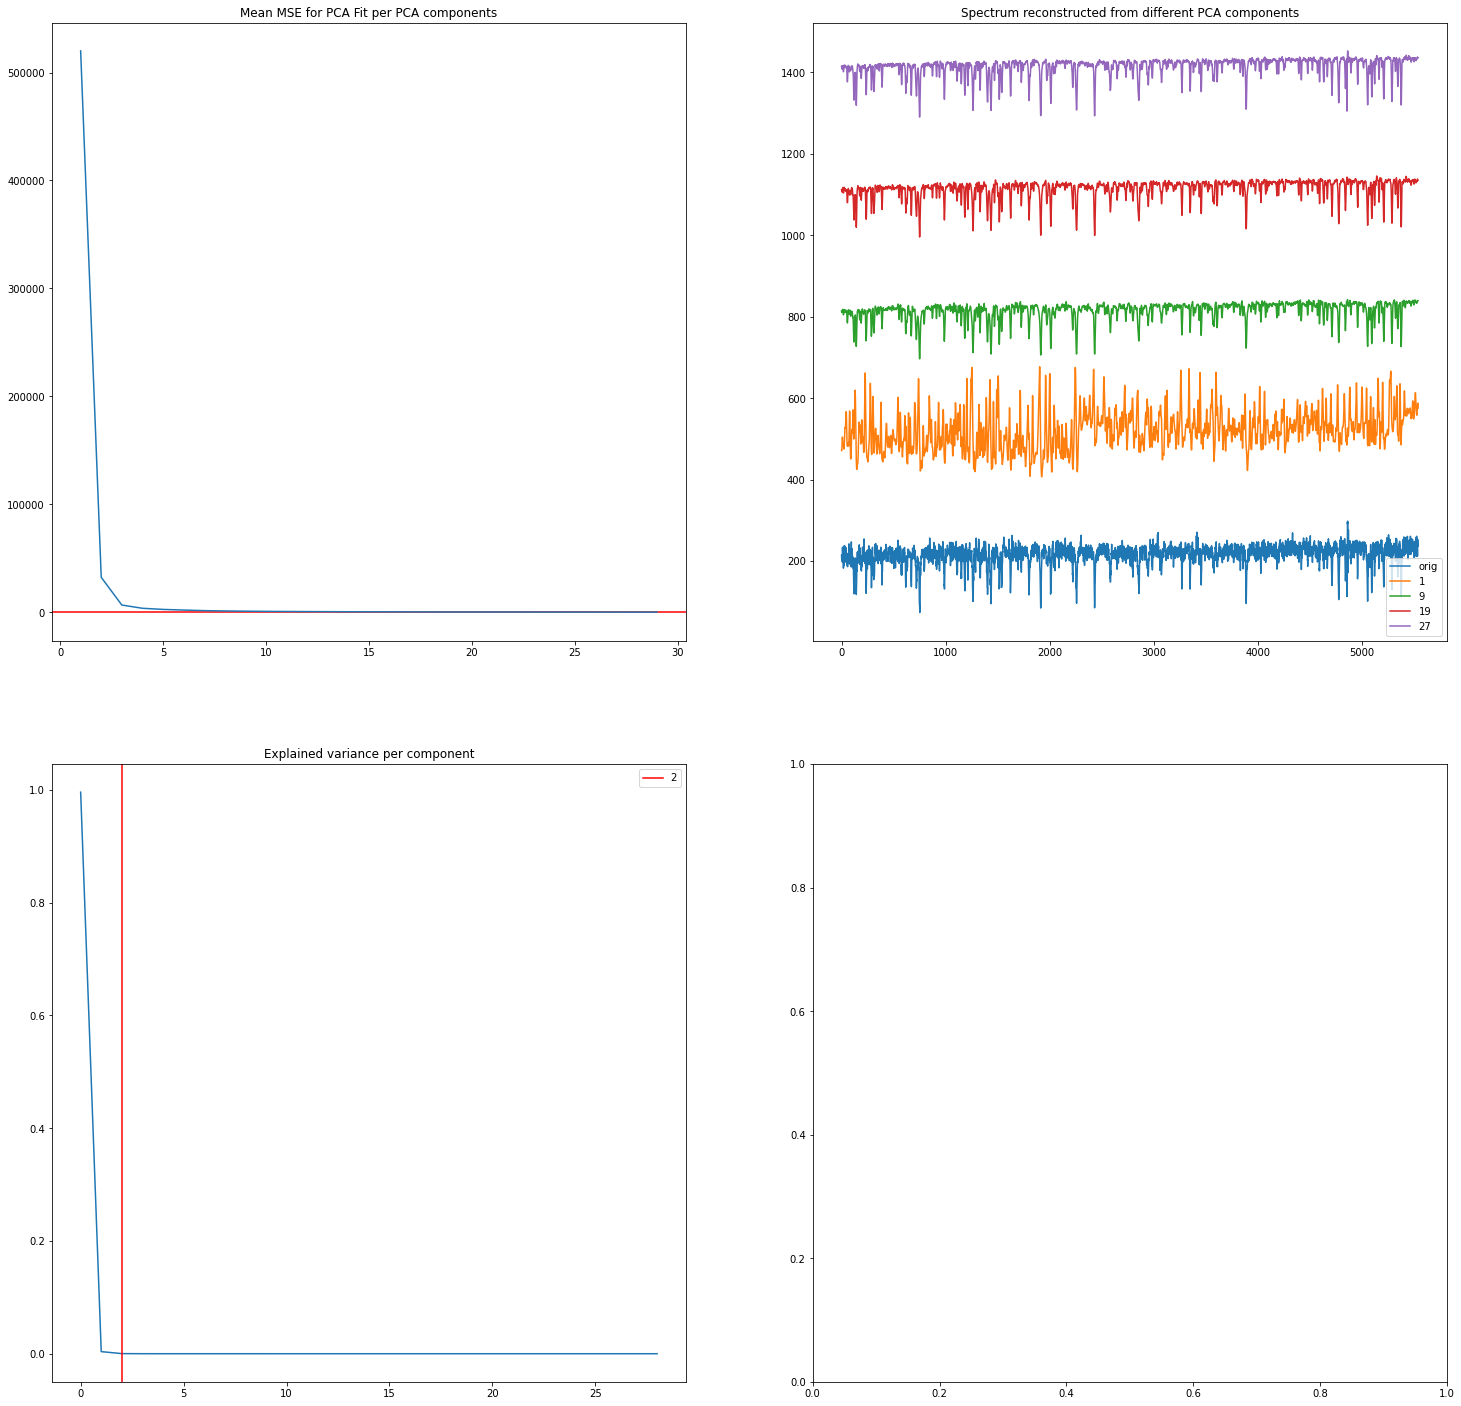

In [13]:
pca.mse_comparison_plot(components=30)


We can see there is a significant increase in goodness of fit after 3 components are used in PCA.

# 2.3 Analysis of Components
In what follows the practice will be very poor. We will utilise that the indices will be in the same order in spectrum_list[i] as in the learning_spectrum list. In future we need a better way of keeping track. The code above will need to be reviewed and changed.

## 2.3.1 Effective temperature

Again no consideration of error here.

In [14]:

analysis=learning_data(spectrum_list,['FEH'])


(-7500.0, 20000.0)

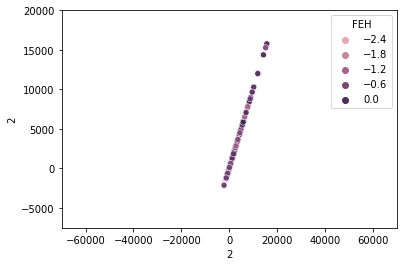

In [15]:
pca_coeff=pd.DataFrame(data=pca.spec_fitted)
pca_analysis=pd.concat([analysis,pca_coeff],axis=1)
pca_analysis=pca_analysis[pca_analysis['FEH']!='nan'].astype(float)




sn.scatterplot(data=pca_analysis,x=2,y=2,hue='FEH')
plt.xlim(-70000,70000)
plt.ylim(-7500,20000)




# 3.0 Standard Neural Nets

In [27]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 

learning_spectra=pca_analysis.drop(columns='FEH').values

class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output
np.shape(learning_spectra)
input=torch.tensor(learning_spectra)

In [23]:
model = Feedforward(np.shape(learning_spectra)[1], 10)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

print(model)

Feedforward(
  (fc1): Linear(in_features=5641, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [30]:
params = list(model.parameters())
print(len(params))
print(params[0].size()) 

output=model(input.float())
len(output)

4
torch.Size([10, 5641])


881

In [54]:
target=torch.tensor(np.array(pca_analysis['FEH'].values)).float()

target=target.view(1,-1).transpose(0,1)

crit=nn.MSELoss()

loss=crit(output,target)
print(loss)

tensor(2.8645, grad_fn=<MseLossBackward0>)


In [55]:
model.zero_grad()
loss.backward()

In [60]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
model.train()

for epoch in range(2000):
# in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = model(input.float())
    loss = criterion(output, target)
    loss.backward()
    optimizer.step() 

loss

tensor(161.7253, grad_fn=<BinaryCrossEntropyBackward0>)